## Import library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
cnn = pd.read_excel('cnn.xlsx')
kompas = pd.read_excel('kompas.xlsx')
tempo = pd.read_excel('tempo.xlsx')
turnbackhoax = pd.read_excel('turnbackhoax.xlsx')

In [3]:
cnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9630 entries, 0 to 9629
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9630 non-null   int64 
 1   Title       9630 non-null   object
 2   Timestamp   9630 non-null   object
 3   FullText    9630 non-null   object
 4   Tags        9627 non-null   object
 5   Author      9630 non-null   object
 6   Url         9630 non-null   object
 7   text_new    9630 non-null   object
 8   hoax        9630 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 677.2+ KB


In [4]:
kompas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4750 non-null   int64 
 1   Title       4729 non-null   object
 2   Timestamp   4729 non-null   object
 3   FullText    4723 non-null   object
 4   Tags        4592 non-null   object
 5   Author      4413 non-null   object
 6   Url         4750 non-null   object
 7   text_new    4723 non-null   object
 8   hoax        4750 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 334.1+ KB


In [5]:
tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6592 entries, 0 to 6591
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6592 non-null   int64 
 1   Title       6592 non-null   object
 2   Timestamp   6592 non-null   object
 3   FullText    6592 non-null   object
 4   Tags        6591 non-null   object
 5   Author      6592 non-null   object
 6   Url         6592 non-null   object
 7   text_new    6592 non-null   object
 8   hoax        6592 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 463.6+ KB


In [6]:
turnbackhoax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10381 entries, 0 to 10380
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    10381 non-null  int64 
 1   Title         10381 non-null  object
 2   Timestamp     10381 non-null  object
 3   FullText      10381 non-null  object
 4   Tags          10381 non-null  object
 5   Author        10381 non-null  object
 6   Url           10381 non-null  object
 7   politik       10381 non-null  int64 
 8   Narasi        10381 non-null  object
 9   Clean Narasi  6502 non-null   object
 10  hoax          10381 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 892.2+ KB


### Menggabungkan data dari berbagai platform berita tersebut menjadi sebuah dataframe.

In [7]:
df = pd.concat([
    cnn[['text_new', 'hoax']].rename(columns={'text_new': 'news', 'hoax': 'label'}),
    kompas[['text_new', 'hoax']].rename(columns={'text_new': 'news', 'hoax': 'label'}),
    tempo[['text_new', 'hoax']].rename(columns={'text_new': 'news', 'hoax': 'label'}),
    turnbackhoax[['Clean Narasi', 'hoax']].rename(columns={'Clean Narasi': 'news', 'hoax': 'label'})
], ignore_index=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31353 entries, 0 to 31352
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    27447 non-null  object
 1   label   31353 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 490.0+ KB


In [9]:
df['label'].unique()

array([0, 1])

### memeriksa data kosong (missing value) dan hapus

In [10]:
print(f"\nMissing Values:\n{df.isnull().sum()}")


Missing Values:
news     3906
label       0
dtype: int64


In [11]:
df = df.dropna()
print(f"\nMissing Values:\n{df.isnull().sum()}")


Missing Values:
news     0
label    0
dtype: int64


### Memeriksa data duplikat dan hapus.

In [12]:
print(f"\nJumlah baris duplikat: {df.duplicated().sum()}")


Jumlah baris duplikat: 16


In [13]:
all_duplicates_boolean = df.duplicated(keep=False)
all_duplicates_data = df[all_duplicates_boolean].sort_values(by=df.columns.tolist())
print(all_duplicates_data) #menampilkan semua kemunculan

                                                    news  label
23609  (Narasi diterjemahkan ke dalam bahasa Indonesi...      1
24120  (Narasi diterjemahkan ke dalam bahasa Indonesi...      1
26634  BERDALIH MELAKUKAN SWEEPING 4 DARI 6 ANGGOTA O...      1
30666  BERDALIH MELAKUKAN SWEEPING 4 DARI 6 ANGGOTA O...      1
30295  INFO DARI KAWAN-KAWAN : VAKSIN KANKER SERVIKS ...      1
31062  INFO DARI KAWAN-KAWAN : VAKSIN KANKER SERVIKS ...      1
29126  INNALILLAHI WAINNA LILLAHI ROZIUN . Hati-hati ...      1
30195  INNALILLAHI WAINNA LILLAHI ROZIUN . Hati-hati ...      1
31303  INSTING MAKELAR AKU Awalnya kaget, membaca ber...      1
31304  INSTING MAKELAR AKU Awalnya kaget, membaca ber...      1
25127  Ini baru berita top!!! :point_down: http://m.a...      1
25212  Ini baru berita top!!! :point_down: http://m.a...      1
26504  KADRUN itu dari PKI Barokallahu fiik Habib @hu...      1
26573  KADRUN itu dari PKI Barokallahu fiik Habib @hu...      1
21227  KISRUH NEGERI ANTARA PRIBUMI DAN 

In [14]:
df = df.drop_duplicates()
print(f"\nJumlah baris duplikat: {df.duplicated().sum()}")


Jumlah baris duplikat: 0


### Melihat distribusi kelas

Disini bisa dilihat bahwa selisih data pada kedua kelas cukup jauh sehingga perlu dilakukan handling imbalance

In [15]:
class_counts = df['label'].value_counts()
print(f"Distribusi kelas: {class_counts}")

Distribusi kelas: label
0    20945
1     6486
Name: count, dtype: int64


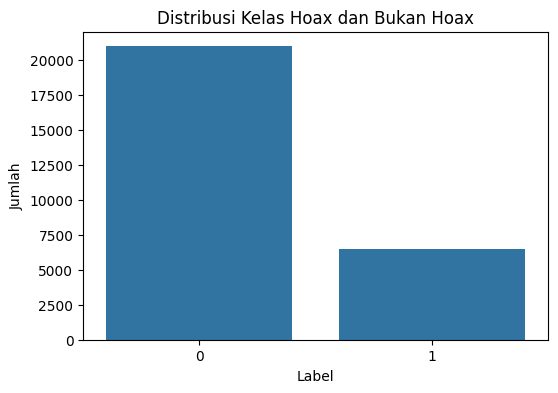

In [16]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title('Distribusi Kelas Hoax dan Bukan Hoax')
plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.show()

### Melihat frekuensi kata pada dokumen berita

In [17]:
df['text_length'] = df['news'].apply(lambda x: len(x.split()))
print(f"\nStatistik Deskriptif Panjang Teks:\n{df['text_length'].describe()}")


Statistik Deskriptif Panjang Teks:
count    27431.000000
mean       202.695308
std        169.052520
min          1.000000
25%         71.000000
50%        198.000000
75%        279.000000
max       4167.000000
Name: text_length, dtype: float64


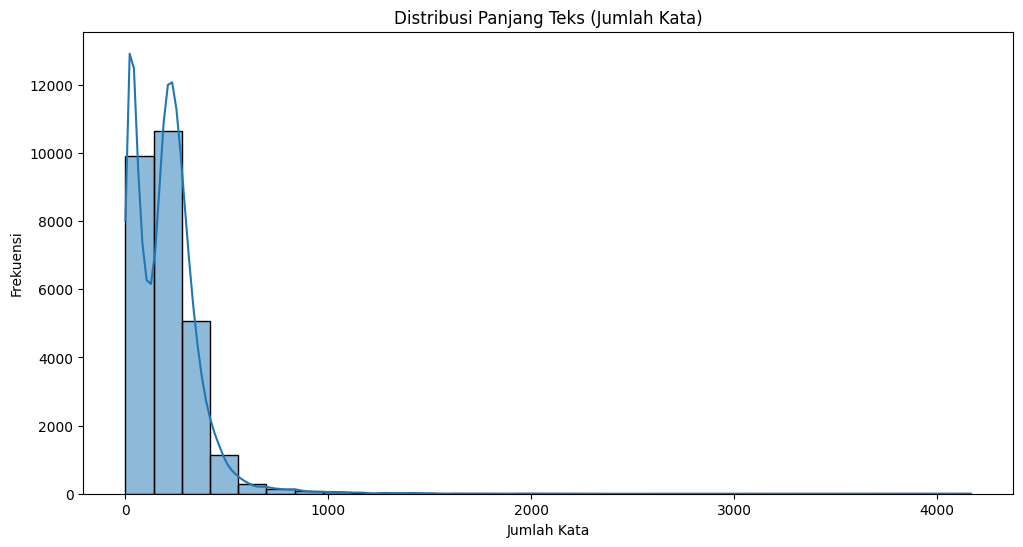

In [18]:
df['text_length'].tolist()
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Distribusi Panjang Teks (Jumlah Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

### Membuat wordcloud untuk melihat kata apa yang sering muncul pada berita hoax dan berita non-hoax

In [19]:
# stop words bahasa inggris
stop_words = set(stopwords.words('indonesian'))
def remove_stopwords(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

C:\Users\user\AppData\Local\Temp\ipykernel_32760\151263836.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='cividis')


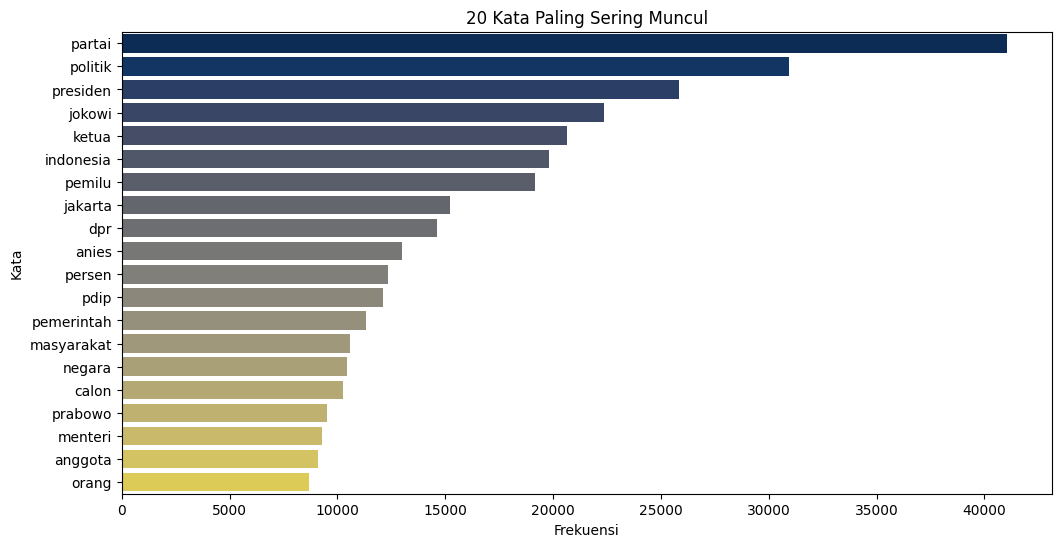

In [20]:
def clean_for_frequency(text):
    text = re.sub(r'[^a-z\s]', '', text.lower())
    text = remove_stopwords(text)
    return text

all_words = ' '.join(df['news'].apply(clean_for_frequency)).split()
word_counts = Counter(all_words)

# Kata-kata yang paling umum (Top 20)
most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(words), palette='cividis')
plt.title('20 Kata Paling Sering Muncul')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

In [21]:
def word_cloud_plot(data, title):
    word_cloud_text = ' '.join(data)
    wordcloud = WordCloud(
        width=800,
        height=400,
        max_words=200,
        background_color='white'
    ).generate(word_cloud_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [22]:
hoax_data = df[df['label'] == 1]['news'].apply(clean_for_frequency)
non_hoax_data = df[df['label'] == 0]['news'].apply(clean_for_frequency)

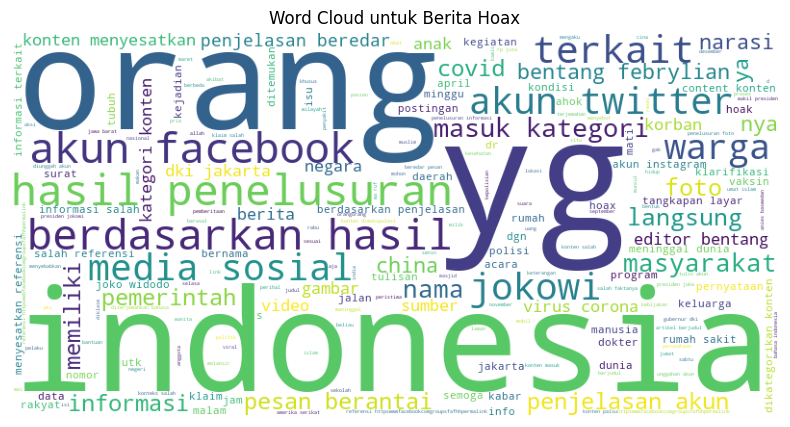

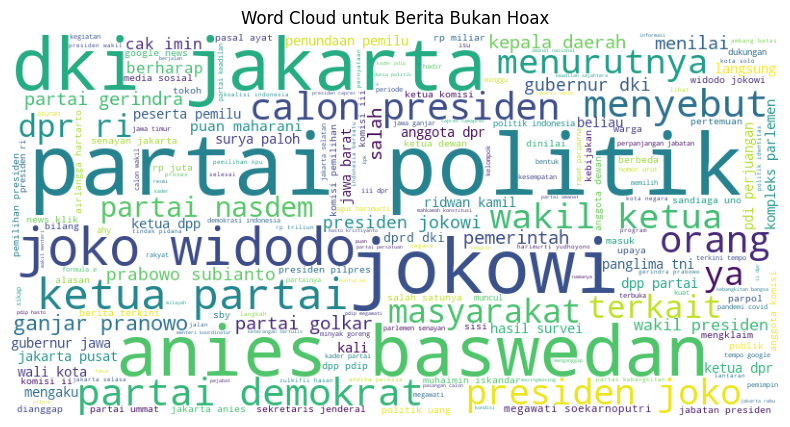

In [23]:
word_cloud_plot(hoax_data, 'Word Cloud untuk Berita Hoax')
word_cloud_plot(non_hoax_data, 'Word Cloud untuk Berita Bukan Hoax')

In [24]:
df_valid = df[df['label'] == 0]
df_hoax  = df[df['label'] == 1]

### Handling Imbalance dengan memotong jumlah data untuk berita non-hoax agar tidak terlalu jomplang dengan data berita hoax.

In [25]:
df_valid_cut = df_valid.sample(
    n=len(df_hoax),       
    random_state=42      
)

### Menggabungkan data berita non-hoax yang telah di potong dengan data berita hoax.

In [26]:
df_balanced = pd.concat([df_valid_cut, df_hoax])

df_balanced = df_balanced.sample(
    frac=1,
    random_state=42
).reset_index(drop=True)

In [27]:
class_counts = df_balanced['label'].value_counts()
print(f"Distribusi kelas: {class_counts}")

Distribusi kelas: label
0    6486
1    6486
Name: count, dtype: int64


In [ ]:
def clean_text(s):
    
    patterns = [         
        r'\(Narasi diterjemahkan.*?\)',
        r"\bhoax\b",
        r"\bsalah\b",
        r"\bhoaks\b",
        r"\bkeliru\b",          
        r"\bmenyesatkan\b",     
        r"\bmanipulasi\b",
        r"\bfitnah\b",
        r"\bhasut\b",
        r"\bvalid\b",
        r"\bmisinformasi\b",
        r"\bdisinformasi\b",
        r"\bfakta\b",
        r"\bklarifikasi\b",
        r"tidak\s*benar",
        r"berita\s*bohong",
        r"ini\s*salah",
        r"hasil periksa fakta",
        r"pemeriksa fakta",
        r"turnbackhoax",
        r"cek fakta",
        r"liputan6",            
        r"kompas\.com",         
        r"cnn indonesia",
        r"\bakun\s*facebook\b",
        r"\bunggahan\b",
        r"\btangkapan\s*layar\b",
        r"\bscreenshot\b",
        
        r'Penjelasan\s*&?\s*Fakta\s*:', 
        r'Narasi\s*:',                   
        r'Klarifikasi\s*:',              
        r'Fakta\s*:',                    
        r'Beredar\s*kabar\s*:', 
        r"kategori\s*:",        
        r"sumber\s*:",          
        r"kesimpulan\s*:",      
        r"penjelasan\s*:",
    ]
    
    s = str(s)
    
    # Menghapus kata yang sekiranya mengindikasikan bahwa teks tersebut adalah hoax
    for pattern in patterns:
        s = re.sub(pattern, '', s, flags=re.IGNORECASE)

    # menghapus URL, tanda baca, HTML tags, dan spasi berlebih, dan lowercase
    s = re.sub(r'http\S+|www\S+|https\S+', '', s)
    s = re.sub(r"[^a-zA-Z0-9\s]", " ", s).lower()
    s = re.sub(r'<.*?>',' ', s)
    s = re.sub(r'\s+',' ', s).strip()
    return s

x= df_balanced['news'].apply(clean_text)


In [29]:
x = x.astype(str)
y = df_balanced['label'].astype(int)

### Splitting data

In [30]:
x_train, x_temp, y_train, y_temp  = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_val, x_test, y_val, y_test  = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train size:", len(x_train))
print("Validation size:", len(x_val))
print("Test size:", len(x_test))

Train size: 10377
Validation size: 1297
Test size: 1298


### Memasukkan tokenizer dan model IndoBERT pretrained.

In [31]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [33]:
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Membuat dataset

In [34]:
train_dataset = TextDataset(
    texts=x_train.tolist(),
    labels=y_train.tolist(),
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = TextDataset(
    texts=x_val.tolist(),
    labels=y_val.tolist(),
    tokenizer=tokenizer,
    max_len=128
)

test_dataset = TextDataset(
    texts=x_test.tolist(),
    labels=y_test.tolist(),
    tokenizer=tokenizer,
    max_len=128
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [35]:
counter = Counter(train_dataset.labels)
counter

Counter({1: 5189, 0: 5188})

In [36]:
optimizer = AdamW(model.parameters(), lr=2e-5)

In [37]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)
    print(f"Training using: {device}")
else:
    device = torch.device("cpu")
    print(f"Training using: {device}")

True
NVIDIA GeForce RTX 4060 Laptop GPU
Training using: cuda


# Training

In [ ]:
model.to(device)
model.train()
for epoch in range(5):
    for batch in train_loader:
        optimizer.zero_grad()
        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.03165602311491966
Epoch 2, Loss: 0.00017230160301551223
Epoch 3, Loss: 0.00015433758380822837
Epoch 4, Loss: 0.0012689788127318025
Epoch 5, Loss: 6.691326416330412e-05


# Evaluasi model

Mulai Evaluasi...
Accuracy : 0.9877
F1 Score : 0.9877

Detail Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       649
           1       1.00      0.98      0.99       649

    accuracy                           0.99      1298
   macro avg       0.99      0.99      0.99      1298
weighted avg       0.99      0.99      0.99      1298



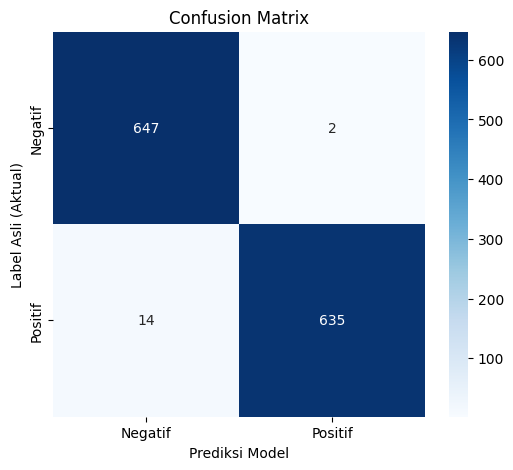

In [39]:
model.eval()
preds = []
trues = []

print("Mulai Evaluasi...")

with torch.no_grad():
    for batch in test_loader: 
        
        # Pindahkan data ke GPU
        b_input_ids = batch["input_ids"].to(device)
        b_attention_mask = batch["attention_mask"].to(device)
        b_labels = batch["labels"].to(device)

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
        )
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Pindahkan hasil prediksi kembali ke CPU
        preds.extend(predictions.cpu().numpy())
        trues.extend(b_labels.cpu().numpy())

# 1. Accuracy & F1 Score
acc = accuracy_score(trues, preds)
f1 = f1_score(trues, preds, average='weighted')

print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nDetail Laporan Klasifikasi:")
print(classification_report(trues, preds))

# Confusion Matrix
cm = confusion_matrix(trues, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Aktual)')
plt.title('Confusion Matrix')
plt.show()

# Mencari best parameter

In [40]:
param_grid = {
    "learning_rate": [2e-5, 3e-5],
    "batch_size": [16, 32],
    "epochs": [3, 5]
}

best_f1 = 0
best_params = None
best_model_state = None

for lr in param_grid["learning_rate"]:
    for batch_size in param_grid["batch_size"]:
        for epochs in param_grid["epochs"]:

            print(f"\nTraining | LR={lr}, BS={batch_size}, Epochs={epochs}")

            train_loader = DataLoader(
                train_dataset,
                batch_size=batch_size,
                pin_memory=True
            )

            val_loader = DataLoader(
                val_dataset,
                batch_size=batch_size,
                shuffle=False,
                pin_memory=True
            )

            model = BertForSequenceClassification.from_pretrained(
                "indobenchmark/indobert-base-p1",
                num_labels=2
            ).to(device)
            

            optimizer = AdamW(model.parameters(), lr=lr)

            # ===== Fine-Tuning =====
            model.train()
            for epoch in range(epochs):
                total_loss = 0
                for batch in train_loader:
                    optimizer.zero_grad()

                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["labels"].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )

                    loss = outputs.loss
                    loss.backward()
                    optimizer.step()

                    total_loss += loss.item()

                print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f}")

            # ===== Validation =====
            model.eval()
            val_preds, val_trues = [], []

            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["labels"].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    )

                    preds = torch.argmax(outputs.logits, dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_trues.extend(labels.cpu().numpy())

            val_f1 = f1_score(val_trues, val_preds, average="weighted")
            print(f"Validation F1: {val_f1:.4f}")

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_params = (lr, batch_size, epochs)
                best_model_state = model.state_dict()



Training | LR=2e-05, BS=16, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.0857
Epoch 2/3 | Loss: 0.0241
Epoch 3/3 | Loss: 0.0101
Validation F1: 0.9861

Training | LR=2e-05, BS=16, Epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | Loss: 0.0811
Epoch 2/5 | Loss: 0.0203
Epoch 3/5 | Loss: 0.0128
Epoch 4/5 | Loss: 0.0097
Epoch 5/5 | Loss: 0.0070
Validation F1: 0.9854

Training | LR=2e-05, BS=32, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.0940
Epoch 2/3 | Loss: 0.0255
Epoch 3/3 | Loss: 0.0131
Validation F1: 0.9815

Training | LR=2e-05, BS=32, Epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | Loss: 0.0845
Epoch 2/5 | Loss: 0.0188
Epoch 3/5 | Loss: 0.0121
Epoch 4/5 | Loss: 0.0085
Epoch 5/5 | Loss: 0.0008
Validation F1: 0.9923

Training | LR=3e-05, BS=16, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.0852
Epoch 2/3 | Loss: 0.0241
Epoch 3/3 | Loss: 0.0191
Validation F1: 0.9869

Training | LR=3e-05, BS=16, Epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | Loss: 0.0824
Epoch 2/5 | Loss: 0.0301
Epoch 3/5 | Loss: 0.0137
Epoch 4/5 | Loss: 0.0105
Epoch 5/5 | Loss: 0.0088
Validation F1: 0.9830

Training | LR=3e-05, BS=32, Epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | Loss: 0.0843
Epoch 2/3 | Loss: 0.0208
Epoch 3/3 | Loss: 0.0132
Validation F1: 0.9854

Training | LR=3e-05, BS=32, Epochs=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | Loss: 0.0824
Epoch 2/5 | Loss: 0.0182
Epoch 3/5 | Loss: 0.0131
Epoch 4/5 | Loss: 0.0118
Epoch 5/5 | Loss: 0.0094
Validation F1: 0.9823


# Evaluasi kembali model dengan best parameter

Mulai Evaluasi...
Accuracy : 0.9777
F1 Score : 0.9777

Detail Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       649
           1       0.97      0.99      0.98       649

    accuracy                           0.98      1298
   macro avg       0.98      0.98      0.98      1298
weighted avg       0.98      0.98      0.98      1298



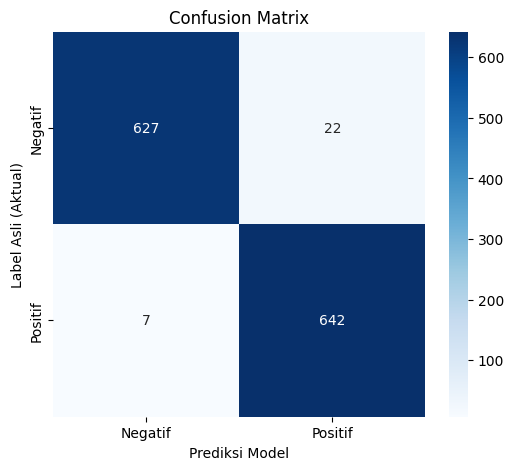

In [41]:
model.eval()
preds = []
trues = []

print("Mulai Evaluasi...")

with torch.no_grad():
    for batch in test_loader: 
        
        # Pindahkan data ke GPU
        b_input_ids = batch["input_ids"].to(device)
        b_attention_mask = batch["attention_mask"].to(device)
        b_labels = batch["labels"].to(device)

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
        )
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Pindahkan hasil prediksi kembali ke CPU
        preds.extend(predictions.cpu().numpy())
        trues.extend(b_labels.cpu().numpy())

# 1. Accuracy & F1 Score
acc = accuracy_score(trues, preds)
f1 = f1_score(trues, preds, average='weighted')

print(f"Accuracy : {acc:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nDetail Laporan Klasifikasi:")
print(classification_report(trues, preds))

# Confusion Matrix
cm = confusion_matrix(trues, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli (Aktual)')
plt.title('Confusion Matrix')
plt.show()

In [42]:
model.save_pretrained("indobert_hoax_detector_best_cut")